In [2]:
!pip install pyGPGO
!pip install --pre -U matplotlib

  Using cached https://files.pythonhosted.org/packages/8d/87/a113c91ba014708114f7635d5c0f6a5e5c773480c5f0a537b257a02d180d/pyGPGO-0.4.0.dev1.tar.gz
  Using cached https://files.pythonhosted.org/packages/7d/c4/6341148ad458b6cd8361b774d7ee6895c38eab88f05331f22304c484ed5d/Theano-1.0.4.tar.gz
  Using cached https://files.pythonhosted.org/packages/32/19/6c94cbadb287745ac38ff1197b9fadd66500b6b9c468e79099b110c6a2e9/pymc3-3.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ea/0c/5f61f1a3d4385d6bf83b83ea495068857ff8dfb89e74824c6e9eb63286d8/patsy-0.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/8b/83472d660e004a69b8e7b3c1dd12a607167774097138445d0dda1a3590dc/arviz-0.6.1-py3-none-any.whl
     |████████████████████████████████| 634kB 1.1MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d8/5b/3098db49a61ccc8583ffead6aedc226f08ff56dc03106b6ec54451e27a30/packaging-20.0-py2.py3-none-any.whl
     |██████████████████████████

# Redifine \_firstRun method of the class GPGO to allow custom initial configuration

In [1]:
def myFirstRun(self, init_rand_configs=None, n_eval=3):
    """
    Performs initial evaluations before fitting GP.

    Parameters
    ----------
    init_rand_configs: list
        Initial random configurations
    n_eval: int
        Number of initial evaluations to perform. Default is 3.

    """
    if init_rand_configs is None:
      self.X = np.empty((n_eval, len(self.parameter_key)))
      self.y = np.empty((n_eval,))
      for i in range(n_eval):
          s_param = self._sampleParam()
          s_param_val = list(s_param.values())
          self.X[i] = s_param_val
          self.y[i] = self.f(**s_param)
    else:
      self.X = np.empty((len(init_rand_configs),len(init_rand_configs[0])))
      self.y = np.empty((len(init_rand_configs),))
      self.init_evals = len(self.y)
      for i in range(len(init_rand_configs)):
        self.X[i] = list(init_rand_configs[i].values())
        self.y[i] = self.f(**init_rand_configs[i])
    self.GP.fit(self.X, self.y)
    self.tau = np.max(self.y)
    if init_rand_configs is None: 
      self.history.append([init_rand_configs[np.argmax(self.y)], self.tau])
    else:
      idx_max_param = np.argmax(self.y)
      self.history.append([{key: self.X[idx_max_param, idx] for idx, key in enumerate(self.parameter_key)}, self.GP.y[-1], self.tau])

# Override updateGP method of the class GPGO to allow saves also for the acquired points

In [2]:
def myUpdateGP(self):
  """
  Updates the internal model with the next acquired point and its evaluation.
  """
  kw = {param: int(self.best[i]) if self.parameter_type[i] == 'int' else float(self.best[i])
        for i, param in enumerate(self.parameter_key)}
  f_new = self.f(**kw)
  self.GP.update(np.atleast_2d(self.best), np.atleast_1d(f_new))
  self.tau = np.max(self.GP.y)
  self.history.append([kw, self.GP.y[-1], self.tau])

# AUTOML

AUTOml for our model

### Define fitness function

In [3]:
import keras.optimizers
from dataset import get_data, get_wdc_data
from fitness import fit
import utils
import json
from utils import get_pretrained_embedding

Using TensorFlow backend.


In [4]:
import gc
gc.collect()

27

In [11]:
config = {
    'train_path' : './dataset/computers/train/computers_splitted_train_medium.json',
    'valid_path' : './dataset/computers/valid/computers_splitted_valid_medium.json',
    'test_path' : "./dataset/computers/test/computers_gs.json",
    'EXP_DIR' : 'data/exps/exp15',
    'PRETRAINED_EMBEDDING_PATH' : './dataset/embeddings/w2v/w2v_title_300Epochs_1MinCount_9ContextWindow_100d.txt',
    'NUM_WORDS' : None,
    'MAX_LEN': 20,
    'BATCH_SIZE' : 32,
    'EMBEDDING_DIM' : 100,
    'RNN_UNITS' : 100,
    'EARLY_STOPPING' : 10,
    'EPOCHS' : 20,
    'TRAINABLE':False
}

In [12]:
def get_fitness_for_automl(config):
  train_gen, val_gen, test_gen, class_weights = get_wdc_data(
            config['train_path'],
            config['valid_path'],
            config['test_path'],
            word_index_path="dataset/title_word_index.json",
            num_words=config['NUM_WORDS'],
            max_len=config['MAX_LEN'],
            batch_size=config['BATCH_SIZE'],
            preprocess_data=True,
            preprocess_method="nltk",
        )
  word_index = json.loads(open("dataset/title_word_index.json").read())
  NUM_WORDS = len(word_index) if config['NUM_WORDS'] is None else NUM_WORDS
  print("* NUM WORDS: ", NUM_WORDS)
  print("* CLASS WEIGHTS:", class_weights)

  embedding_matrix = None
  if config['PRETRAINED_EMBEDDING_PATH'] is not None:
      embedding_matrix = get_pretrained_embedding(
          config['PRETRAINED_EMBEDDING_PATH'], NUM_WORDS + 1, 
          config['EMBEDDING_DIM'], word_index
      )

  def fitness(
      lr=0.001,
      embedding_dim=150,
      embedding_dropout=0.3, 
      rnn_units=100,
      convs_filter_banks=4,
      convs_kernel_size=2,
      pool_size=2,
      denses_depth=3,
      mlp_dropout=0.3,  
      optimizer_type='adam', 
      similarity_type=0):
    
    optimizer = getattr(keras.optimizers, optimizer_type)(lr=lr)
    matrix_similarity_function = getattr(utils, 'dot_similarity' if similarity_type == 0 else 'cosine_similarity')
    model, results = fit(
        train_gen,
        val_gen,
        NUM_WORDS,
        config['EMBEDDING_DIM'],
        config['MAX_LEN'],
        matrix_similarity_function,
        config['EXP_DIR'],
        config['EARLY_STOPPING'],
        denses_depth=denses_depth,
        activation="sigmoid",
        embedding_matrix=embedding_matrix,
        embedding_trainable=config['TRAINABLE'],
        embedding_dropout=embedding_dropout,
        rnn_type="LSTM",
        rnn_units=rnn_units,
        convs_filter_banks=convs_filter_banks,
        convs_kernel_size=convs_kernel_size,
        pool_size=pool_size,
        mlp_dropout=mlp_dropout,
        epochs=config['EPOCHS'],
        verbosity=1,
        callbacks=False,
        class_weights=None,
        optimizer=None
    )
    return results[3]
  return fitness

### ExpectedImprovement

In [13]:
import numpy as np
import functools

from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition

from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D 
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
    
furtherEvaluations = 10
# param = {'lr': ('cont', [0.01,0.1]),'momentum': ('cont', [0.1,0.9])} 
 
param = {
    'lr': ('cont', [0.00001, 1.0]),
    'rnn_units': ('int', [50, 150]),
    'similarity_type': ('int', [0, 1]),
    'convs_filter_banks': ('int', [4, 64]),
    'convs_kernel_size': ('int', [2, 4]),
    'pool_size': ('int', [2, 4]),
    'denses_depth': ('int', [1, 6]),
} 

init_rand_configs = [{
    'lr':0.0001,
    'rnn_units':200,
    'similarity_type': 1,
    'convs_filter_banks':32,
    'convs_kernel_size':3,
    'pool_size':2,
    'denses_depth':3,
}] 

# creating a GP surrogate model with a Squared Exponantial covariance function,
# aka kernel
sexp = squaredExponential()
sur_model = GaussianProcess(sexp)
fitness = get_fitness_for_automl(config)
# setting the acquisition function
acq = Acquisition(mode="ExpectedImprovement")

# creating an object Bayesian Optimization
bo_step1_expected = GPGO(sur_model,acq,fitness,param,n_jobs=1)
bo_step1_expected._firstRun = functools.partial(myFirstRun, bo_step1_expected)
bo_step1_expected.updateGP = functools.partial(myUpdateGP, bo_step1_expected)
bo_step1_expected._firstRun(init_rand_configs=init_rand_configs)
bo_step1_expected.logger._printInit(bo_step1_expected)

* PREPROCESS DATA
* DONE
* FOUND 4362 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 3444 unique vocabs
* PREPROCESS DATA
* DONE
* FOUND 2791 unique vocabs
* NUM WORDS:  4764
* CLASS WEIGHTS: [0.63919052 2.29609929]
* LOADING EMBEDDINGS MATRIX
* FOUND 4764 WORD VECTORS
* FOUND 4764 vector representations out of 4765 words
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embeddi

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 100)      476500      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 20, 100)      0           embedding_2[0][0]          

Epoch 1/20
202/202 [==============================] - 14s 68ms/step - loss: 0.6149 - accuracy: 0.6912 - val_loss: 0.5892 - val_accuracy: 0.7831
Epoch 2/20
202/202 [==============================] - 11s 53ms/step - loss: 0.5506 - accuracy: 0.7734 - val_loss: 0.5501 - val_accuracy: 0.7806
Epoch 3/20
202/202 [==============================] - 11s 55ms/step - loss: 0.5427 - accuracy: 0.7774 - val_loss: 0.5277 - val_accuracy: 0.7806
Epoch 4/20
202/202 [==============================] - 10s 52ms/step - loss: 0.5380 - accuracy: 0.7808 - val_loss: 0.5380 - val_accuracy: 0.7819
Epoch 5/20
202/202 [==============================] - 11s 52ms/step - loss: 0.5379 - accuracy: 0.7803 - val_loss: 0.5306 - val_accuracy: 0.7825
Epoch 6/20
202/202 [==============================] - 11s 55ms/step - loss: 0.5319 - accuracy: 0.7795 - val_loss: 0.5406 - val_accuracy: 0.7819
Epoch 7/20
202/202 [==============================] - 11s 56ms/step - loss: 0.5302 - accuracy: 0.7817 - val_loss: 0.5149 - val_accuracy:

202/202 [==============================] - 10s 49ms/step - loss: 0.5012 - accuracy: 0.7834 - val_loss: 0.4453 - val_accuracy: 0.7800
Epoch 10/20
202/202 [==============================] - 11s 53ms/step - loss: 0.4928 - accuracy: 0.7893 - val_loss: 0.4473 - val_accuracy: 0.7831
Epoch 11/20
202/202 [==============================] - 11s 54ms/step - loss: 0.4766 - accuracy: 0.7969 - val_loss: 0.4059 - val_accuracy: 0.7738
Epoch 12/20
202/202 [==============================] - 11s 52ms/step - loss: 0.4630 - accuracy: 0.8003 - val_loss: 0.3923 - val_accuracy: 0.7688
Epoch 13/20
202/202 [==============================] - 10s 50ms/step - loss: 0.4336 - accuracy: 0.8150 - val_loss: 0.3584 - val_accuracy: 0.7788
Epoch 14/20
202/202 [==============================] - 10s 51ms/step - loss: 0.4207 - accuracy: 0.8198 - val_loss: 0.4066 - val_accuracy: 0.7769
Epoch 15/20
202/202 [==============================] - 10s 50ms/step - loss: 0.4001 - accuracy: 0.8354 - val_loss: 0.3709 - val_accuracy: 0.76

202/202 [==============================] - 10s 50ms/step - loss: 0.4092 - accuracy: 0.8072 - val_loss: 0.4963 - val_accuracy: 0.7881
Epoch 18/20
202/202 [==============================] - 10s 50ms/step - loss: 0.3941 - accuracy: 0.8108 - val_loss: 0.4794 - val_accuracy: 0.7944
Epoch 19/20
202/202 [==============================] - 10s 51ms/step - loss: 0.3839 - accuracy: 0.8238 - val_loss: 0.4848 - val_accuracy: 0.7850
Epoch 20/20
202/202 [==============================] - 10s 50ms/step - loss: 0.3721 - accuracy: 0.8286 - val_loss: 0.4283 - val_accuracy: 0.7950
* FINAL EVALUATION [0.795, 0.7696266644193495, 0.795, 0.7738348876921057]
4      	 [1.67437442e-01 1.19625127e+02 3.30777445e-05 7.93849795e+00
 2.00000000e+00 2.00000000e+00 1.00000000e+00]. 	  0.7738348876921057 	 0.7738348876921057
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to    

Epoch 1/20
202/202 [==============================] - 13s 65ms/step - loss: 0.6285 - accuracy: 0.6764 - val_loss: 0.6027 - val_accuracy: 0.7837
Epoch 2/20
202/202 [==============================] - 10s 50ms/step - loss: 0.5673 - accuracy: 0.7576 - val_loss: 0.5487 - val_accuracy: 0.7825
Epoch 3/20
202/202 [==============================] - 10s 51ms/step - loss: 0.5554 - accuracy: 0.7661 - val_loss: 0.5180 - val_accuracy: 0.7825
Epoch 4/20
202/202 [==============================] - 10s 51ms/step - loss: 0.5521 - accuracy: 0.7704 - val_loss: 0.5453 - val_accuracy: 0.7831
Epoch 5/20
202/202 [==============================] - 11s 54ms/step - loss: 0.5503 - accuracy: 0.7718 - val_loss: 0.5410 - val_accuracy: 0.7825
Epoch 6/20
202/202 [==============================] - 11s 55ms/step - loss: 0.5450 - accuracy: 0.7755 - val_loss: 0.5261 - val_accuracy: 0.7825
Epoch 7/20
202/202 [==============================] - 11s 53ms/step - loss: 0.5452 - accuracy: 0.7746 - val_loss: 0.5188 - val_accuracy:

202/202 [==============================] - 10s 49ms/step - loss: 0.5390 - accuracy: 0.7806 - val_loss: 0.5325 - val_accuracy: 0.7825
Epoch 7/20
202/202 [==============================] - 10s 49ms/step - loss: 0.5387 - accuracy: 0.7811 - val_loss: 0.5342 - val_accuracy: 0.7825
Epoch 8/20
202/202 [==============================] - 10s 51ms/step - loss: 0.5339 - accuracy: 0.7816 - val_loss: 0.5337 - val_accuracy: 0.7825
Epoch 9/20
202/202 [==============================] - 12s 58ms/step - loss: 0.5305 - accuracy: 0.7816 - val_loss: 0.5364 - val_accuracy: 0.7825
Epoch 10/20
202/202 [==============================] - 19s 96ms/step - loss: 0.5339 - accuracy: 0.7822 - val_loss: 0.5494 - val_accuracy: 0.7825
Epoch 11/20
202/202 [==============================] - 13s 63ms/step - loss: 0.5256 - accuracy: 0.7816 - val_loss: 0.5685 - val_accuracy: 0.7825
Epoch 12/20
202/202 [==============================] - 10s 50ms/step - loss: 0.5220 - accuracy: 0.7822 - val_loss: 0.5553 - val_accuracy: 0.7825


202/202 [==============================] - 10s 49ms/step - loss: 0.4506 - accuracy: 0.8043 - val_loss: 0.5380 - val_accuracy: 0.7900
Epoch 15/20
202/202 [==============================] - 11s 52ms/step - loss: 0.4389 - accuracy: 0.8100 - val_loss: 0.5414 - val_accuracy: 0.7881
Epoch 16/20
202/202 [==============================] - 10s 52ms/step - loss: 0.4265 - accuracy: 0.8130 - val_loss: 0.6129 - val_accuracy: 0.7681
Epoch 17/20
202/202 [==============================] - 10s 49ms/step - loss: 0.4185 - accuracy: 0.8196 - val_loss: 0.6416 - val_accuracy: 0.7312
Epoch 18/20
202/202 [==============================] - 10s 49ms/step - loss: 0.3972 - accuracy: 0.8278 - val_loss: 0.5535 - val_accuracy: 0.7569
Epoch 19/20
202/202 [==============================] - 10s 49ms/step - loss: 0.3899 - accuracy: 0.8332 - val_loss: 0.5532 - val_accuracy: 0.7663
Epoch 20/20
202/202 [==============================] - 10s 49ms/step - loss: 0.3803 - accuracy: 0.8351 - val_loss: 0.6423 - val_accuracy: 0.73

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 20, 100)      476500      input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 20, 100)      0           embedding_11[0][0]        

Epoch 20/20
202/202 [==============================] - 10s 51ms/step - loss: 0.4769 - accuracy: 0.7819 - val_loss: 0.6277 - val_accuracy: 0.7825
* FINAL EVALUATION [0.7825, 0.6123062499999999, 0.7825, 0.6870196353436185]
10     	 [  0.53106542 120.           0.          13.           3.
   3.           5.        ]. 	  0.6870196353436185 	 0.7894598395094934


/home/belerico/.local/share/virtualenvs/aml-project-EQl709OG/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


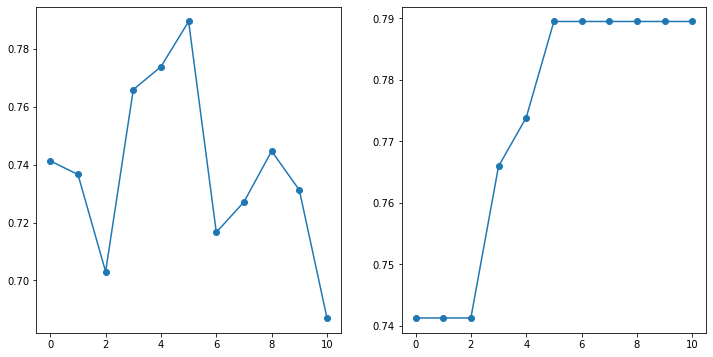

In [14]:
bo_step1_expected.run(furtherEvaluations, resume=True)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot([val[1] for val in bo_step1_expected.history], marker="o")
plt.subplot(1, 2, 2)
plt.plot([val[2] for val in bo_step1_expected.history], marker="o")

In [16]:
import pickle
with open('exp100embedding_w2v.pickle', 'wb') as handle:
    pickle.dump(bo_step1_expected.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
bo_step1_expected.history

[[{'lr': 0.0001,
   'rnn_units': 200.0,
   'similarity_type': 1.0,
   'convs_filter_banks': 32.0,
   'convs_kernel_size': 3.0,
   'pool_size': 2.0,
   'denses_depth': 3.0},
  0.7412700332516907,
  0.7412700332516907],
 [{'lr': 0.5178079008780593,
   'rnn_units': 120,
   'similarity_type': 0,
   'convs_filter_banks': 7,
   'convs_kernel_size': 2,
   'pool_size': 2,
   'denses_depth': 1},
  0.7365986349658509,
  0.7412700332516907],
 [{'lr': 0.5445389598586403,
   'rnn_units': 119,
   'similarity_type': 0,
   'convs_filter_banks': 7,
   'convs_kernel_size': 2,
   'pool_size': 2,
   'denses_depth': 1},
  0.7030268597257731,
  0.7412700332516907],
 [{'lr': 0.03619624097538518,
   'rnn_units': 117,
   'similarity_type': 0,
   'convs_filter_banks': 10,
   'convs_kernel_size': 2,
   'pool_size': 2,
   'denses_depth': 1},
  0.7659203343602556,
  0.7659203343602556],
 [{'lr': 0.16743744219964665,
   'rnn_units': 119,
   'similarity_type': 0,
   'convs_filter_banks': 7,
   'convs_kernel_size': 2

#### Plot selected points during run


KeyError: 'momentum'

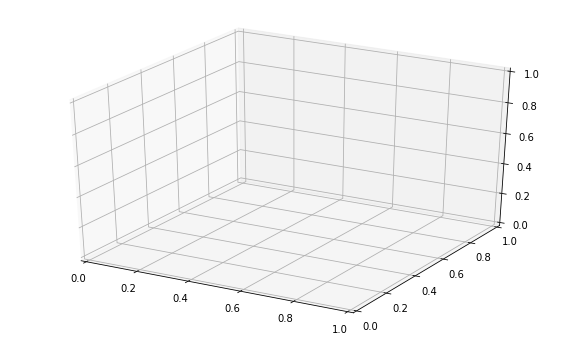

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

x = [val[0]['lr'] for val in bo_step1_expected.history]
y = [val[0]['momentum'] for val in bo_step1_expected.history]
z = [val[1] for val in bo_step1_expected.history]

img = ax.scatter(x, y, z, c=z, marker="o", cmap="coolwarm", depthshade=True)
plt.colorbar(img)
ax.set_xlabel('Learning rate',labelpad=10)
ax.set_ylabel('Momentum',labelpad=10)
ax.set_zlabel('Accuracy',labelpad=10)
ax.dist = 13

#### Plot best seen points during run

KeyError: ignored

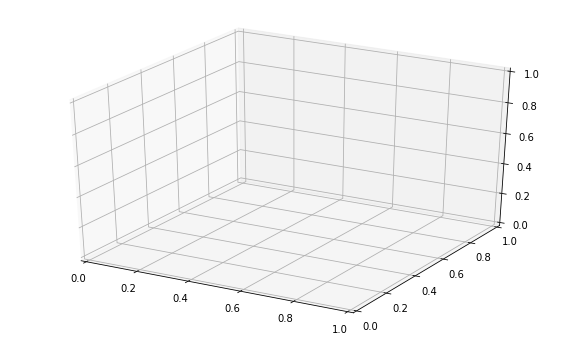

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection='3d')

x = [val[0]['lr'] for val in bo_step1_expected.history]
y = [val[0]['momentum'] for val in bo_step1_expected.history]
z = [val[2] for val in bo_step1_expected.history]

img = ax.scatter(x, y, z, c=z, marker="o", cmap="coolwarm")
plt.colorbar(img,)
ax.set_xlabel('Learning rate',labelpad=10)
ax.set_ylabel('Momentum',labelpad=10)
ax.set_zlabel('Accuracy',labelpad=10)
ax.dist = 13